In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load


In [2]:
import sys
sys.path.insert(0, 'data_loading_and_pretreatments/')

In [3]:
from global_variables import define_data_folder
data_folder = "../data"
define_data_folder(data_folder)
conditions = ["Viral Pneumonia", "Lung_Opacity", "COVID",  "Normal"]
model_folders = "../models/"


In [4]:
# Chargement de la fonction d'importation et formattage des images
from data_loading_and_pretreatments.data_importation_and_formatting_v2 import load_img_multiple_cond_in_df, set_img_size, load_masked_img_multiple_cond_in_df

In [5]:
# Chargement du script de séparation des données
from train_val_test_split import train_val_test_split

In [6]:
# Choix de la résolution des images à charger
IMG_SIZE = 299
set_img_size(IMG_SIZE)
print("IMG_SIZE = ", IMG_SIZE) 

IMG_SIZE =  299


# 1. Classification des images non masquées

## Importation et préparation des données

In [7]:
## Importation des images
SAMPLE_SIZE = 2500
sample_size_viral_pneum = int(np.min([1345, SAMPLE_SIZE/2]))
sample_size_lung_opa = SAMPLE_SIZE - sample_size_viral_pneum
img_df = load_img_multiple_cond_in_df(selected_conditions=conditions, sample_sizes=[sample_size_viral_pneum, sample_size_lung_opa, SAMPLE_SIZE, SAMPLE_SIZE])


In [8]:
img_df.replace({'Viral Pneumonia' : 'Pulmonary infection',
                       'Lung_Opacity' : 'Pulmonary infection'}, inplace=True)

In [9]:
img_df.label.value_counts()

Pulmonary infection    2500
COVID                  2500
Normal                 2500
Name: label, dtype: int64

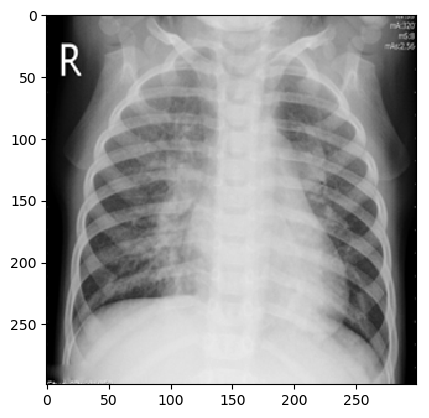

In [10]:
plt.imshow(np.array(img_df.drop(columns='label').iloc[0,:]).reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

## Séparation en échantillons d'apprentissage, de validation et de test

In [11]:
# Encodage de la variable cible en numérique
labenc = LabelEncoder()
y = labenc.fit_transform(img_df.label)

# Séparation des échantillons
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(img_df.drop(columns='label'), 
                                                                      y,
                                                                      test_val_sizes=(0.2, 0.2), random_state=42)

In [12]:
labenc.classes_

array(['COVID', 'Normal', 'Pulmonary infection'], dtype=object)

In [13]:
print(X_train.shape[0],X_train.shape[0]/7500)
print(X_val.shape[0], X_val.shape[0]/7500)
print(X_test.shape[0], X_test.shape[0]/7500)


4800 0.64
1200 0.16
1500 0.2


## Extraction de features à l'aide d'une PCA

In [14]:
if os.path.exists(os.path.join(model_folders, "PCA/", "pca_unmasked_img.joblib")):
    pca90 = load(os.path.join(model_folders, "PCA/", "pca_unmasked_img.joblib"))

    X_train_pca = pca90.transform(X_train)
else :
    # PCA conservant 90 % de l'information
    pca90 = PCA(n_components=0.9, random_state=42)

    X_train_pca = pca90.fit_transform(X_train)
    dump(pca90, os.path.join(model_folders, "PCA/", "pca_unmasked_img.joblib"))

print(X_train_pca.shape) # 345 composants

X_val_pca = pca90.transform(X_val)

print(X_val_pca.shape)

(4800, 57)
(1200, 57)


## Modèle knn optimisé

### Apprentissage

In [ ]:
# Instanciation
knn_pca = neighbors.KNeighborsClassifier()

# Optimisation des paramètres
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
folds = list(skf.split(X_train_pca, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

# grid_param = {'metric' : ['euclidean', 'chebyshev', 'correlation', 'cosine'],  'n_neighbors' : [2, 3, 5, 10, 50, 100]}
grid_param = [
    {'metric' : ['minkowski'],  'n_neighbors' : [2, 3, 5, 10, 50], 'p' : [1,2,5]},
    {'metric' : ['chebyshev'], 'n_neighbors' : [2, 3, 5, 10, 50]},
    {'metric' : ['correlation'], 'n_neighbors' : [2, 3, 5, 10, 50]},
    {'metric' : ['cosine'], 'n_neighbors' : [2, 3, 5, 10, 50]}
]
grid_knn = GridSearchCV(knn_pca, param_grid = grid_param, cv=folds)
grid_knn.fit(X_train_pca, y_train)

print(grid_knn.best_params_)

{'metric': 'minkowski', 'n_neighbors': 10, 'p': 1}


### Evaluation des performances sur l'échantillon de validation

In [ ]:
print("Score entraînement :",grid_knn.score(X_train_pca, y_train))

print("Score validation :",grid_knn.score(X_val_pca, y_val))
print("\n Performances et matrice de confusion sur l'échantillon de validation :")

y_val_best = grid_knn.predict(X_val_pca)
# print("f1_score validation :",f1_score(y_val, y_val_best))

print(classification_report(y_val, y_val_best))
cross_tab_val = pd.crosstab(y_val_best, y_val, rownames=['pred'], colnames=['true'])
cross_tab_val.index = labenc.classes_
cross_tab_val.columns = labenc.classes_

print(cross_tab_val)

print("\n f1 score validation :", f1_score(y_val, y_val_best, average='micro'))


Score entraînement : 0.8247916666666667
Score validation : 0.7725

 Performances et matrice de confusion sur l'échantillon de validation :
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       371
           1       0.79      0.77      0.78       391
           2       0.82      0.74      0.78       438

    accuracy                           0.77      1200
   macro avg       0.77      0.77      0.77      1200
weighted avg       0.78      0.77      0.77      1200

                     COVID  Normal  Pulmonary infection
COVID                  298      59                   62
Normal                  31     303                   50
Pulmonary infection     42      29                  326

 f1 score validation : 0.7725


## Evaluation sur l'échantillon de test

Une fois le modèle entraîné et validé sur les échantillons de test et validation, on le réentraîne et évalue sur l'échantillon de test qui permettra des comparaison inter-modèles.

In [ ]:
print(grid_knn.best_params_)

{'metric': 'minkowski', 'n_neighbors': 10, 'p': 1}


In [ ]:
# Réentraînement du modèle optimal :

knn_opt = neighbors.KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=1)

X_train_val_pca = np.concatenate([X_train_pca, X_val_pca], axis=0)

y_train_val = np.concatenate([y_train, y_val])

knn_opt.fit(X_train_val_pca, y_train_val)

# Evaluation sur l'échantillon de test

X_test_pca = pca90.transform(X_test)

y_test_pred = knn_opt.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

cross_tab_test = pd.crosstab(y_test_pred, y_test, rownames=['pred'], colnames=['true'])
cross_tab_test.index = labenc.classes_
cross_tab_test.columns = labenc.classes_

print(cross_tab_test)

print("\n f1 score :", f1_score(y_test, y_test_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       492
           1       0.78      0.76      0.77       481
           2       0.81      0.78      0.79       527

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500

                     COVID  Normal  Pulmonary infection
COVID                  402      63                   57
Normal                  42     367                   61
Pulmonary infection     48      51                  409

 f1 score : 0.7853333333333333


# 2. Classification des images avec masques

## Importation et préparation des données

In [13]:
## Importation des images

masked_img_df = load_masked_img_multiple_cond_in_df(selected_conditions=conditions, sample_sizes=[1250, 1250, 2500, 2500])


In [14]:
masked_img_df.replace({'Viral Pneumonia' : 'Pulmonary infection',
                       'Lung_Opacity' : 'Pulmonary infection'}, inplace=True)

In [ ]:
masked_img_df.label.value_counts()

Pulmonary infection    2500
COVID                  2500
Normal                 2500
Name: label, dtype: int64

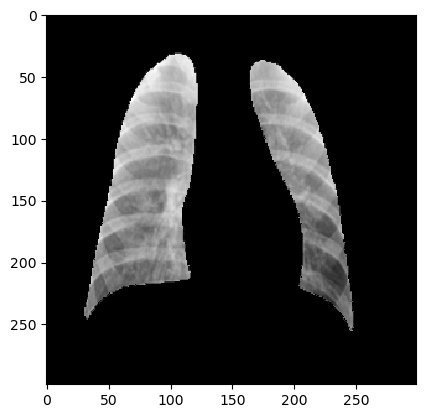

In [15]:
plt.imshow(np.array(masked_img_df.drop(columns='label').iloc[0,:]).reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

## Séparation en échantillons d'apprentissage, de validation et de test

In [16]:
# Encodage de la variable cible en numérique
labenc = LabelEncoder()
y = labenc.fit_transform(masked_img_df.label)

# Séparation des échantillons
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(masked_img_df.drop(columns='label'), 
                                                                      y,
                                                                      test_val_sizes=(0.2, 0.2), random_state=42)

In [ ]:
labenc.classes_

array(['COVID', 'Normal', 'Pulmonary infection'], dtype=object)

In [ ]:
print(X_train.shape[0],X_train.shape[0]/7500)
print(X_val.shape[0], X_val.shape[0]/7500)
print(X_test.shape[0], X_test.shape[0]/7500)


4800 0.64
1200 0.16
1500 0.2


## Extraction de features à l'aide d'une PCA

In [17]:
if os.path.exists(os.path.join(model_folders, "PCA/", "pca_masked_img.joblib")):
    pca90_masks = load(os.path.join(model_folders, "PCA/", "pca_masked_img.joblib"))

    X_train_pca_masks = pca90_masks.transform(X_train)
else :
    # PCA conservant 90 % de l'information
    pca90_masks = PCA(n_components=0.9, random_state=42)

    X_train_pca_masks = pca90_masks.fit_transform(X_train)
    dump(pca90_masks, os.path.join(model_folders, "PCA/", "pca_masked_img.joblib"))

print(X_train_pca_masks.shape) # 353 composants

X_val_pca_masks = pca90_masks.transform(X_val)

print(X_val_pca_masks.shape)

(4800, 353)
(1200, 353)


## Modèle knn optimisé

### Apprentissage


In [ ]:
# Instanciation
knn_pca_masks = neighbors.KNeighborsClassifier()

# Optimisation des paramètres
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
folds = list(skf.split(X_train_pca_masks, y_train)) # Découpage du jeu de données de validation croisée au sein de l'échantillon d'apprentissage

# grid_param = {'metric' : ['euclidean', 'chebyshev', 'correlation', 'cosine'],  'n_neighbors' : [2, 3, 5, 10, 50, 100]}
grid_param = [
    {'metric' : ['minkowski'],  'n_neighbors' : [2, 3, 5, 10, 50], 'p' : [1,2,5]},
    {'metric' : ['chebyshev'], 'n_neighbors' : [2, 3, 5, 10, 50]},
    {'metric' : ['correlation'], 'n_neighbors' : [2, 3, 5, 10, 50]},
    {'metric' : ['cosine'], 'n_neighbors' : [2, 3, 5, 10, 50]}
]
grid_knn_masks = GridSearchCV(knn_pca_masks, param_grid = grid_param, cv=folds)
grid_knn_masks.fit(X_train_pca_masks, y_train)

print(grid_knn_masks.best_params_)

{'metric': 'cosine', 'n_neighbors': 10}


### Evaluation des performances sur l'échantillon de validation

In [ ]:
print("Score entraînement :",grid_knn_masks.score(X_train_pca_masks, y_train))

print("Score validation :",grid_knn_masks.score(X_val_pca_masks, y_val))

print("\n Performances et matrice de confusion sur l'échantillon de validation :")

y_val_best = grid_knn_masks.predict(X_val_pca_masks)
# print("f1_score validation :",f1_score(y_val, y_val_best))

print(classification_report(y_val, y_val_best))
cross_tab_val = pd.crosstab(y_val_best, y_val, rownames=['pred'], colnames=['true'])
cross_tab_val.index = labenc.classes_
cross_tab_val.columns = labenc.classes_

print(cross_tab_val)

print("\n f1 score validation :", f1_score(y_val, y_val_best, average='micro'))




Score entraînement : 0.730625
Score validation : 0.6366666666666667

 Performances et matrice de confusion sur l'échantillon de validation :
              precision    recall  f1-score   support

           0       0.53      0.64      0.58       371
           1       0.63      0.71      0.67       391
           2       0.79      0.56      0.66       438

    accuracy                           0.64      1200
   macro avg       0.65      0.64      0.64      1200
weighted avg       0.66      0.64      0.64      1200

                     COVID  Normal  Pulmonary infection
COVID                  239      91                  117
Normal                  87     279                   75
Pulmonary infection     45      21                  246


## Evaluation des performances sur les échantillons de test :

In [ ]:
print(grid_knn_masks.best_params_)

{'metric': 'cosine', 'n_neighbors': 10}


In [ ]:
# Réentraînement du modèle optimal :

knn_opt_masks = neighbors.KNeighborsClassifier(n_neighbors=10, metric='cosine')

X_train_val_pca_masks = np.concatenate([X_train_pca_masks, X_val_pca_masks], axis=0)

y_train_val = np.concatenate([y_train, y_val])

knn_opt_masks.fit(X_train_val_pca_masks, y_train_val)

# Evaluation sur l'échantillon de test

X_test_pca_masks = pca90_masks.transform(X_test)

y_test_pred = knn_opt_masks.predict(X_test_pca_masks)

print(classification_report(y_test, y_test_pred))

cross_tab_test = pd.crosstab(y_test_pred, y_test, rownames=['pred'], colnames=['true'])
cross_tab_test.index = labenc.classes_
cross_tab_test.columns = labenc.classes_

print(cross_tab_test)

print("\n f1 score validation :", f1_score(y_test, y_test_pred, average='micro'))


              precision    recall  f1-score   support

           0       0.58      0.60      0.59       492
           1       0.63      0.73      0.68       481
           2       0.76      0.62      0.68       527

    accuracy                           0.65      1500
   macro avg       0.66      0.65      0.65      1500
weighted avg       0.66      0.65      0.65      1500

                     COVID  Normal  Pulmonary infection
COVID                  296      99                  118
Normal                 122     353                   81
Pulmonary infection     74      29                  328

 f1 score validation : 0.6513333333333333
